In [ ]:
!pip install imbalanced-learn seaborn

## Dataset Formation

In [9]:
import pandas as pd
import ast
import numpy as np
from glob import glob
import os

In [10]:
import numpy as np
import pandas as pd

def compute_features(group):
    features = {}
    # Number of events
    
    # Extract move events
    move_events = group[group["event_type"] == "move"]
    features["num_moves"] = len(move_events)
    # Extract click events
    click_events = group[group["event_type"] == "click"]
    features["num_clicks"] = len(click_events)
    # Extract scroll events
    scroll_events = group[group["event_type"] == "scroll"]
    features["num_scrolls"] = len(scroll_events)

    # Click positions
    if len(click_events) >= 1:
        features["click_x_mean"] = click_events["x"].mean()
        features["click_y_mean"] = click_events["y"].mean()
    else:
        features["click_x_mean"] = 0
        features["click_y_mean"] = 0

    # Compute movement distance and related features
    if len(move_events) >= 2:
        move_events = move_events.sort_values("time")
        x = move_events["x"].values
        y = move_events["y"].values
        t = move_events["time"].values
        dx = np.diff(x)
        dy = np.diff(y)
        dt = np.diff(t)

        # Handle zeros in dt to prevent division by zero
        valid = dt != 0
        dx = dx[valid]
        dy = dy[valid]
        dt = dt[valid]
        distances = np.sqrt(dx**2 + dy**2)
        total_distance = np.sum(distances)
        features["movement_distance"] = total_distance

        if len(distances) > 0:
            # Velocity calculations
            velocities = distances / dt
            features["velocity_mean"] = np.mean(velocities)
            features["velocity_max"] = np.max(velocities)
            features["velocity_min"] = np.min(velocities)
            features["velocity_sd"] = np.std(velocities)
            features["velocity_x_mean"] = np.mean(dx / dt)
            features["velocity_y_mean"] = np.mean(dy / dt)
        else:
            # No valid velocities
            features.update({
                "velocity_mean": 0,
                "velocity_max": 0,
                "velocity_min": 0,
                "velocity_sd": 0,
                "velocity_x_mean": 0,
                "velocity_y_mean": 0,
            })
            velocities = np.array([])

        # Acceleration calculations
        if len(velocities) >= 2:
            dv = np.diff(velocities)
            dt_acc = dt[1:]  # Time intervals for acceleration
            valid_acc = dt_acc != 0
            dv = dv[valid_acc]
            dt_acc = dt_acc[valid_acc]
            if len(dv) > 0:
                dv_dt = dv / dt_acc
                features["acceleration_mean"] = np.mean(dv_dt)
                features["acceleration_max"] = np.max(dv_dt)
                features["acceleration_min"] = np.min(dv_dt)
                features["acceleration_sd"] = np.std(dv_dt)
            else:
                features.update({
                    "acceleration_mean": 0,
                    "acceleration_max": 0,
                    "acceleration_min": 0,
                    "acceleration_sd": 0,
                })
                dv_dt = np.array([])
        else:
            features.update({
                "acceleration_mean": 0,
                "acceleration_max": 0,
                "acceleration_min": 0,
                "acceleration_sd": 0,
            })
            dv_dt = np.array([])

        # Jerk calculations
        if len(dv_dt) >= 2:
            da = np.diff(dv_dt)
            dt_jerk = dt_acc[1:]
            valid_jerk = dt_jerk != 0
            da = da[valid_jerk]
            dt_jerk = dt_jerk[valid_jerk]
            if len(da) > 0:
                da_dt = da / dt_jerk
                features["jerk_mean"] = np.mean(da_dt)
                features["jerk_sd"] = np.std(da_dt)
            else:
                features.update({
                    "jerk_mean": 0,
                    "jerk_sd": 0,
                })
        else:
            features.update({
                "jerk_mean": 0,
                "jerk_sd": 0,
            })

        # Angular velocity calculations
        angles = np.arctan2(dy, dx)
        d_angle = np.diff(angles)
        d_angle = (d_angle + np.pi) % (2 * np.pi) - np.pi  # Normalize angles
        dt_ang = dt[1:]
        valid_ang = dt_ang != 0
        d_angle = d_angle[valid_ang]
        dt_ang = dt_ang[valid_ang]
        if len(d_angle) > 0:
            angular_velocity = d_angle / dt_ang
            features["angular_velocity_mean"] = np.mean(angular_velocity)
            features["angular_velocity_sd"] = np.std(angular_velocity)
        else:
            features.update({
                "angular_velocity_mean": 0,
                "angular_velocity_sd": 0,
            })
    else:
        features.update({
            "movement_distance": 0,
            "velocity_mean": 0,
            "velocity_max": 0,
            "velocity_min": 0,
            "velocity_sd": 0,
            "velocity_x_mean": 0,
            "velocity_y_mean": 0,
            "acceleration_mean": 0,
            "acceleration_max": 0,
            "acceleration_min": 0,
            "acceleration_sd": 0,
            "jerk_mean": 0,
            "jerk_sd": 0,
            "angular_velocity_mean": 0,
            "angular_velocity_sd": 0,
        })

    # Movement duration
    if len(move_events) >= 1:
        features["movement_duration"] = move_events["time"].max() - move_events["time"].min()
    else:
        features["movement_duration"] = 0

    # Pause time (idle cursor time)
    total_time = group["time"].max() - group["time"].min()
    features["total_time"] = total_time
    features["pause_time"] = total_time - features["movement_duration"]

    # Flips (directional changes)
    if len(move_events) >= 2 and len(dx) >= 2:
        features["flips_x"] = np.sum(np.diff(np.sign(dx)) != 0)
        features["flips_y"] = np.sum(np.diff(np.sign(dy)) != 0)
    else:
        features["flips_x"] = 0
        features["flips_y"] = 0

    # Number of pauses (idle periods)
    if len(move_events) >= 2 and len(dt) >= 1:
        idle_threshold = 0.2  # Define a threshold for idle time
        pauses = dt[dt > idle_threshold]
        features["pause_count"] = len(pauses)
    else:
        features["pause_count"] = 0

    # Hold time for clicks
    if len(click_events) >= 1:
        pressed_events = click_events[click_events["pressed"] == True]
        released_events = click_events[click_events["pressed"] == False]
        if len(pressed_events) == len(released_events):
            hold_times = released_events["time"].values - pressed_events["time"].values
            features["hold_time_mean"] = np.mean(hold_times) if len(hold_times) > 0 else 0
            features["hold_time_sd"] = np.std(hold_times) if len(hold_times) > 1 else 0
        else:
            features["hold_time_mean"] = 0
            features["hold_time_sd"] = 0
    else:
        features["hold_time_mean"] = 0
        features["hold_time_sd"] = 0

    return pd.Series(features)

In [11]:

files = glob('recordings/*.txt')

for file in files:
    
    new_filename = file.replace('.txt', '_features.csv').replace("recordings", "train_data")
    if os.path.exists(new_filename): continue
        
    events = []
    monitors = []
    with open(file, 'r') as f:
        monitors.append(ast.literal_eval(f.readline().strip()))
        for line in f:
            event = ast.literal_eval(line.strip())
            events.append(event)

    # Convert events to a list of dictionaries
    width, height = monitors[0][1], monitors[0][2]
    event_list = []
    for event in events:
        if event[0] == 'move':
            event_dict = {'event_type': 'move', 'time': event[1], 'x': event[2]/width, 'y': event[3]/height}
        elif event[0] == 'click':
            event_dict = {'event_type': 'click', 'time': event[1], 'x': event[2]/width, 'y': event[3]/height,
                        'button': event[4], 'pressed': event[5]}
        elif event[0] == 'scroll':
            event_dict = {'event_type': 'scroll', 'time': event[1], 'x': event[2]/width, 'y': event[3]/height,
                        'dx': event[4], 'dy': event[5]}
        else:
            continue
        event_list.append(event_dict)

    # Convert to DataFrame and sort by time
    df = pd.DataFrame(event_list)
    df = df.sort_values('time').reset_index(drop=True)

    # Step 2: Organize events into time windows
    start_time = df['time'].min()
    df['timestamp'] = ((df['time'] - start_time) // 0.1).astype(int)
    
    unique_timestamps = df['timestamp'].unique()
    blank_timestamps = [i for i in range(unique_timestamps.min(), unique_timestamps.max() + 1) if i not in unique_timestamps]
    
    # insert blank rows for missing timestamps
    new_rows = []
    for ts in blank_timestamps:
        new_rows.append({'timestamp': ts})
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    df = df.sort_values('timestamp').reset_index(drop=True).fillna(0)
    

    # Step 3: Extract features for each time window
    # Apply the feature extraction function to each time window
    features_df = df.groupby('timestamp').apply(compute_features, include_groups=False).reset_index(drop=True)
    
    features_df.to_csv(file.replace('.txt', '_features.csv').replace("recordings", "train_data"), index=False)
    print(f"Features saved to {file.replace('.txt', '_features.csv')}")

## Trainer

In [12]:
classification_classes = {
  "web_browsing": 0, # web
  # "ppt": 1, # design tools,
  # "reading": 2, # reading papers
  "finding_mines": 3, # game
  "chess": 3, # game
  "youtube": 4, # youtube
  # "chatting": 5, # chatting
}

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

In [20]:


def process_class_data(file, window_size, window_interval=5, split=0.8):
    df = pd.read_csv(file)
    df = df.ffill().bfill()
    df = df.dropna()
    
    index = int(split * df.shape[0])
    
    train_df = df.iloc[:index]
    test_df = df.iloc[index:]
    
    train_windows = []
    for i in range(0, train_df.shape[0] - window_size + 1, window_interval):
        window = train_df.iloc[i:i+window_size]
        features = window.values.flatten()
        train_windows.append(features)
    
    test_windows = []
    for i in range(0, test_df.shape[0] - window_size + 1, window_interval):
        window = test_df.iloc[i:i+window_size]
        features = window.values.flatten()
        test_windows.append(features)
        
    return train_windows, test_windows

def prepare_data(window_size=50, window_interval=5, resample=True):
    # Process the data for each class
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for tag, label in classification_classes.items():
        files = glob(f'train_data/{tag}_*.csv')
        for file in files:
            # print(f'Processing {file} for class {tag}')
            train_windows, test_windows = process_class_data(file, window_size, window_interval, split=0.8)
            X_train.extend(train_windows)
            X_test.extend(test_windows)
            y_train.extend([label] * len(train_windows))
            y_test.extend([label] * len(test_windows))

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    X_train = np.nan_to_num(X_train, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
    X_test = np.nan_to_num(X_test, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Print per-class counts
    # for label, count in zip(*np.unique(y_train, return_counts=True)):
    #     print(f'Class {label}: {count} samples')

    if resample:
        oversampler = RandomOverSampler(random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # print(f'X_train shape: {X_train.shape} -> {X_resampled.shape}')
    # print(f'X_test shape: {X_test.shape}')
    return X_train, X_test, y_train, y_test

In [15]:
from sklearn.metrics import confusion_matrix

def train(model_name, window_size, window_interval):
    if model_name == 'boosting':
        model = HistGradientBoostingClassifier(random_state=42)
    elif model_name == 'random_forest':
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'svm':
        model = SVC(random_state=42, n_jobs=-1)
    elif model_name == 'logistic_regression':
        model = LogisticRegression(tol=1e-3, n_jobs=-1)
    elif model_name == 'poly_regression':
        model = make_pipeline(PolynomialFeatures(degree=5), LogisticRegression(n_jobs=-1))
    elif model_name == 'knn':
        model = KNeighborsClassifier(n_jobs=-1)
    else:
        raise ValueError(f"Unknown MODEL: {model_name}")

    X_resampled, X_test, y_resampled, y_test = prepare_data(window_size, window_interval)
    
    model.fit(X_resampled, y_resampled)

    # Predict on the test set and evaluate performance
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    # return conf matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, f1, cm

In [16]:
category_names = []
for label in sorted(classification_classes.values()):
  name = ""
  for tag, l in classification_classes.items():
    if l == label:
      if name != "":
        name += "/"
      name += tag
  if not name in category_names:
    category_names.append(name)
category_names

['web_browsing', 'finding_mines/chess', 'youtube']

Model: boosting, Window Size: 300, Accuracy: 0.9556509298998569, F1: 0.9542141381898728


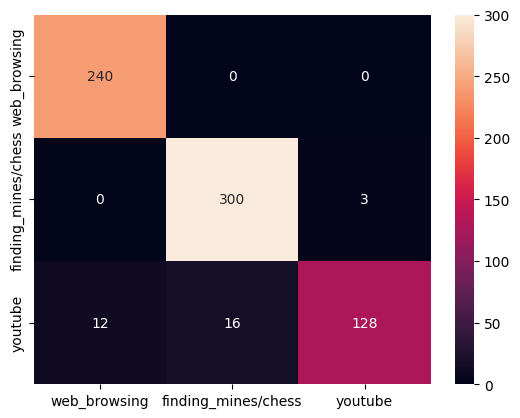

Model: boosting, Window Size: 100, Accuracy: 0.9056603773584906, F1: 0.9015657467042615


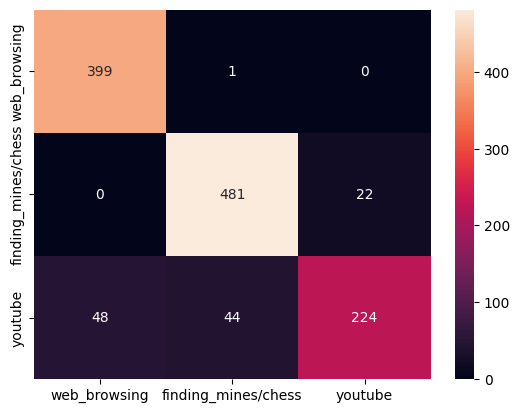

Model: boosting, Window Size: 50, Accuracy: 0.8724981467753892, F1: 0.8695791523587417


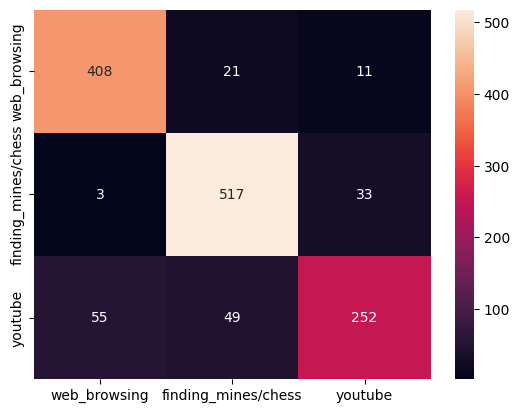

Model: boosting, Window Size: 20, Accuracy: 0.8037841625788367, F1: 0.803408638049866


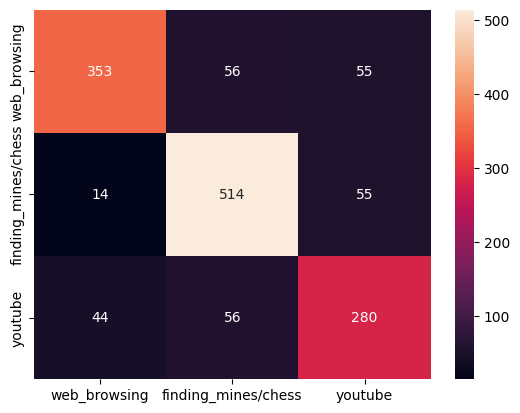

Model: random_forest, Window Size: 300, Accuracy: 0.8955650929899857, F1: 0.8927490191800384


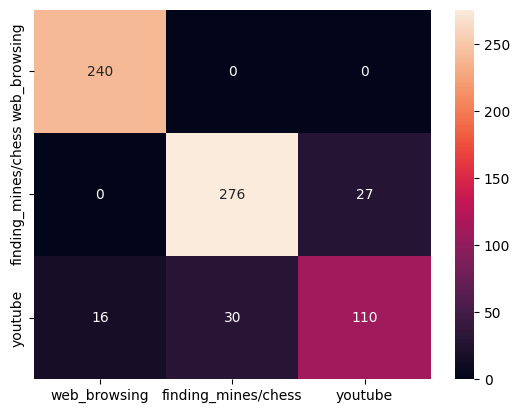

Model: random_forest, Window Size: 100, Accuracy: 0.8777686628383922, F1: 0.8743938321546305


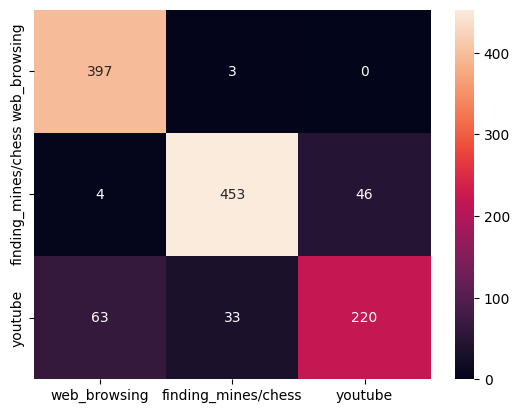

Model: random_forest, Window Size: 50, Accuracy: 0.8621200889547813, F1: 0.8579029348805897


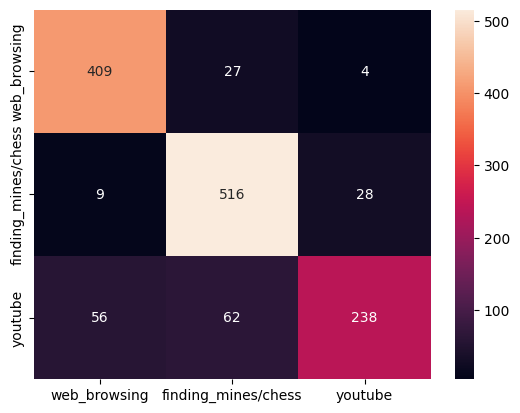

Model: random_forest, Window Size: 20, Accuracy: 0.779957953749124, F1: 0.7790011395423788


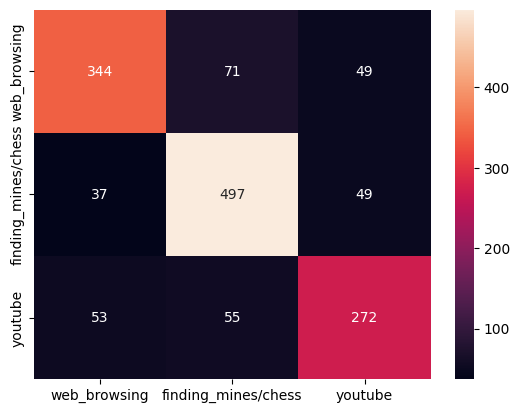

Model: logistic_regression, Window Size: 300, Accuracy: 0.9384835479256081, F1: 0.9363430542350544


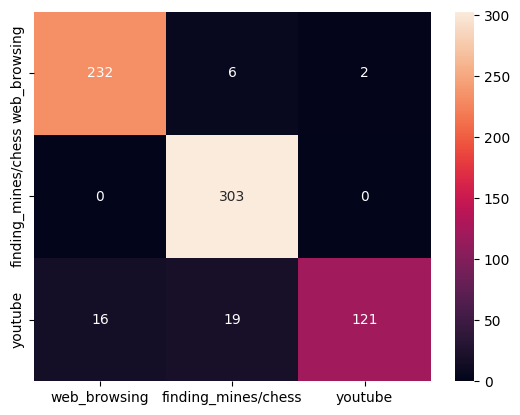

Model: logistic_regression, Window Size: 100, Accuracy: 0.7850697292863003, F1: 0.784088342891195


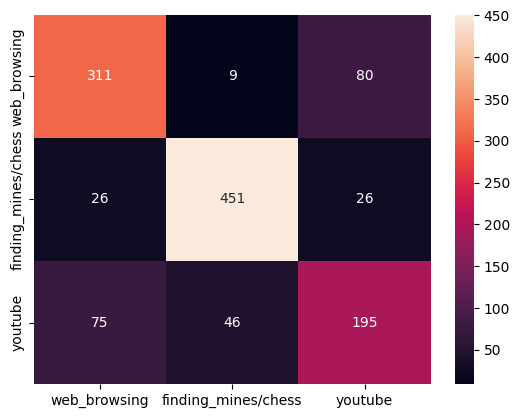

Model: logistic_regression, Window Size: 50, Accuracy: 0.782060785767235, F1: 0.7837879910791887


/Users/jangsus1/.env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


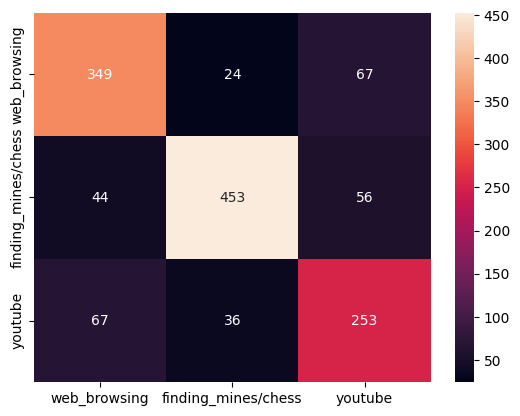

Model: logistic_regression, Window Size: 20, Accuracy: 0.7217939733707078, F1: 0.7256211862510468


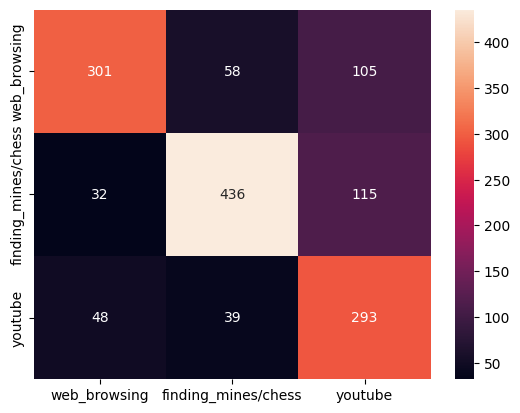

Model: knn, Window Size: 300, Accuracy: 0.45493562231759654, F1: 0.4533309164643699


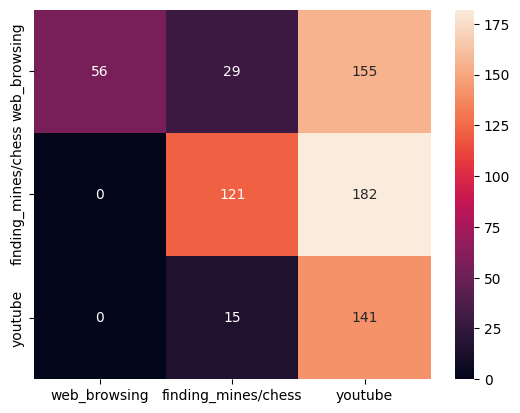

Model: knn, Window Size: 100, Accuracy: 0.44052502050861364, F1: 0.4457490279012646


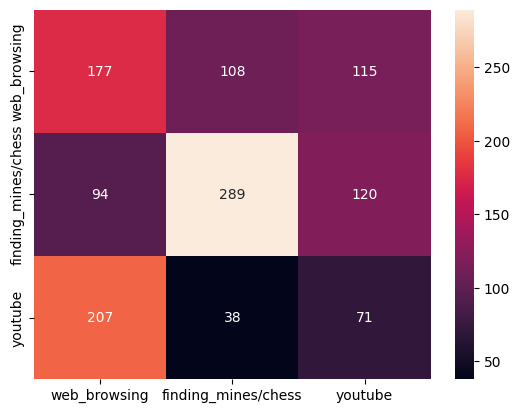

Model: knn, Window Size: 50, Accuracy: 0.4729429206819867, F1: 0.45456052133615465


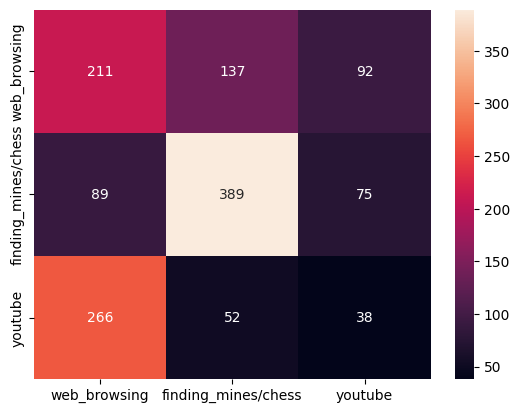

Model: knn, Window Size: 20, Accuracy: 0.4877365101611773, F1: 0.4418815747827661


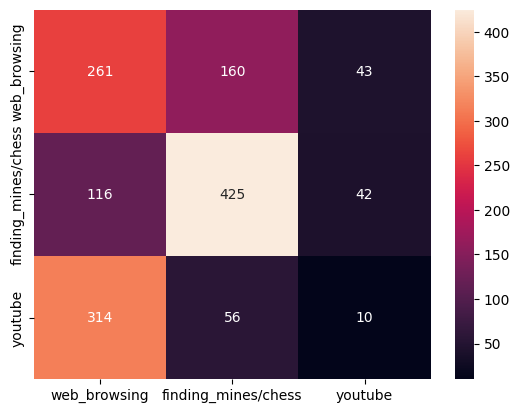

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

window_interval = 5

# Options: 'boosting', 'random_forest', 'svm', 'logistic_regression', 'poly_regression', 'knn'
for model_name in ['boosting', 'random_forest', 'logistic_regression', 'knn', 'poly_regression', 'svm']: 
  for window_size in [300, 100, 50, 20]:
    acc, f1, cm = train(model_name, window_size, window_interval)
    print(f"Model: {model_name}, Window Size: {window_size}, Accuracy: {acc}, F1: {f1}")
    # plot cm
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=category_names, yticklabels=category_names)
    plt.show()

## Unsupervised Learning

In [25]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming prepare_data is defined and provides data
X_train, X_test, y_train, y_test = prepare_data(50, 5, resample=False)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")



X_train shape: (5758, 1400)
y_train shape: (5758,)


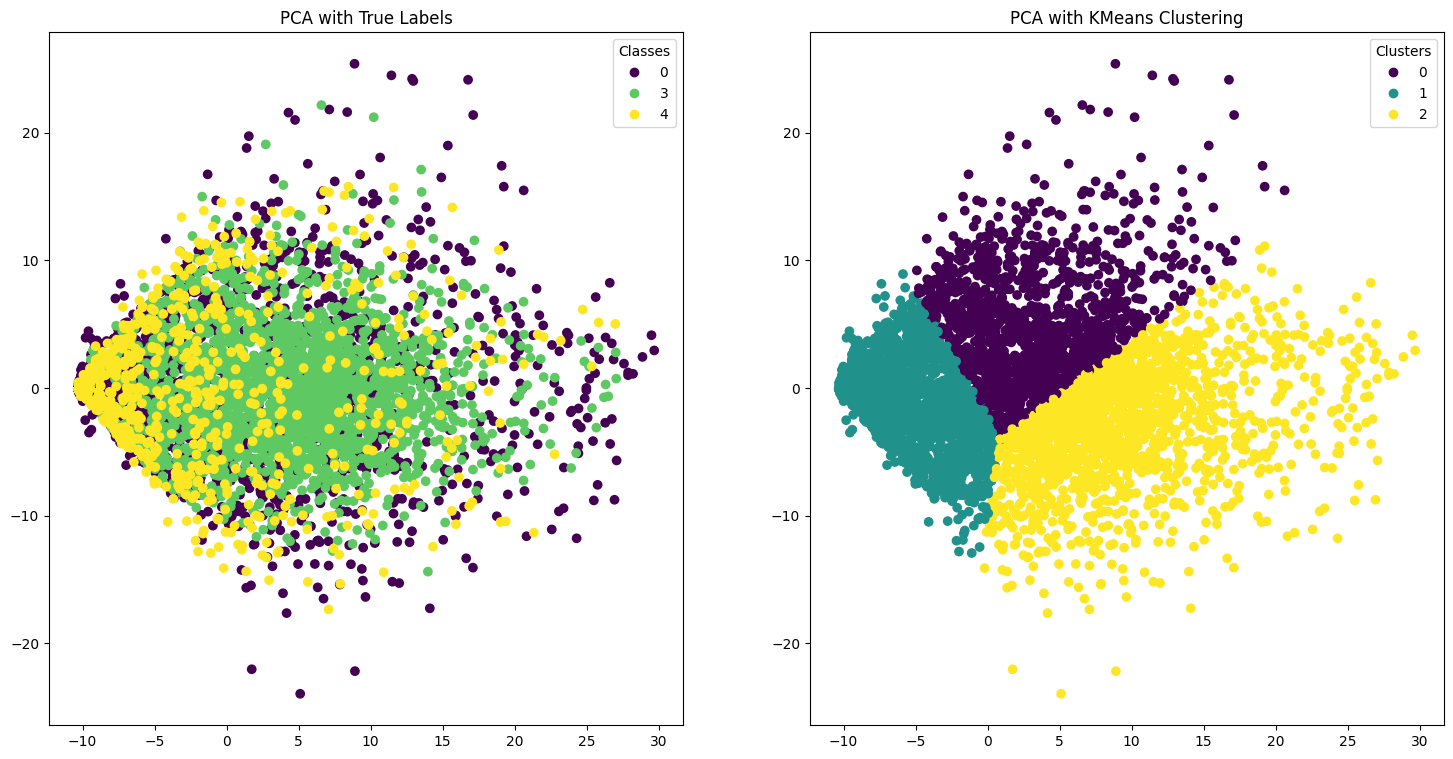

In [27]:
# perform PCA on the data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust number of clusters if needed
kmeans_labels = kmeans.fit_predict(X_train_pca)

# Plot PCA results with true labels
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.title("PCA with True Labels")
plt.legend(*scatter.legend_elements(), title="Classes")

# Plot PCA results with KMeans labels
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("PCA with KMeans Clustering")
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

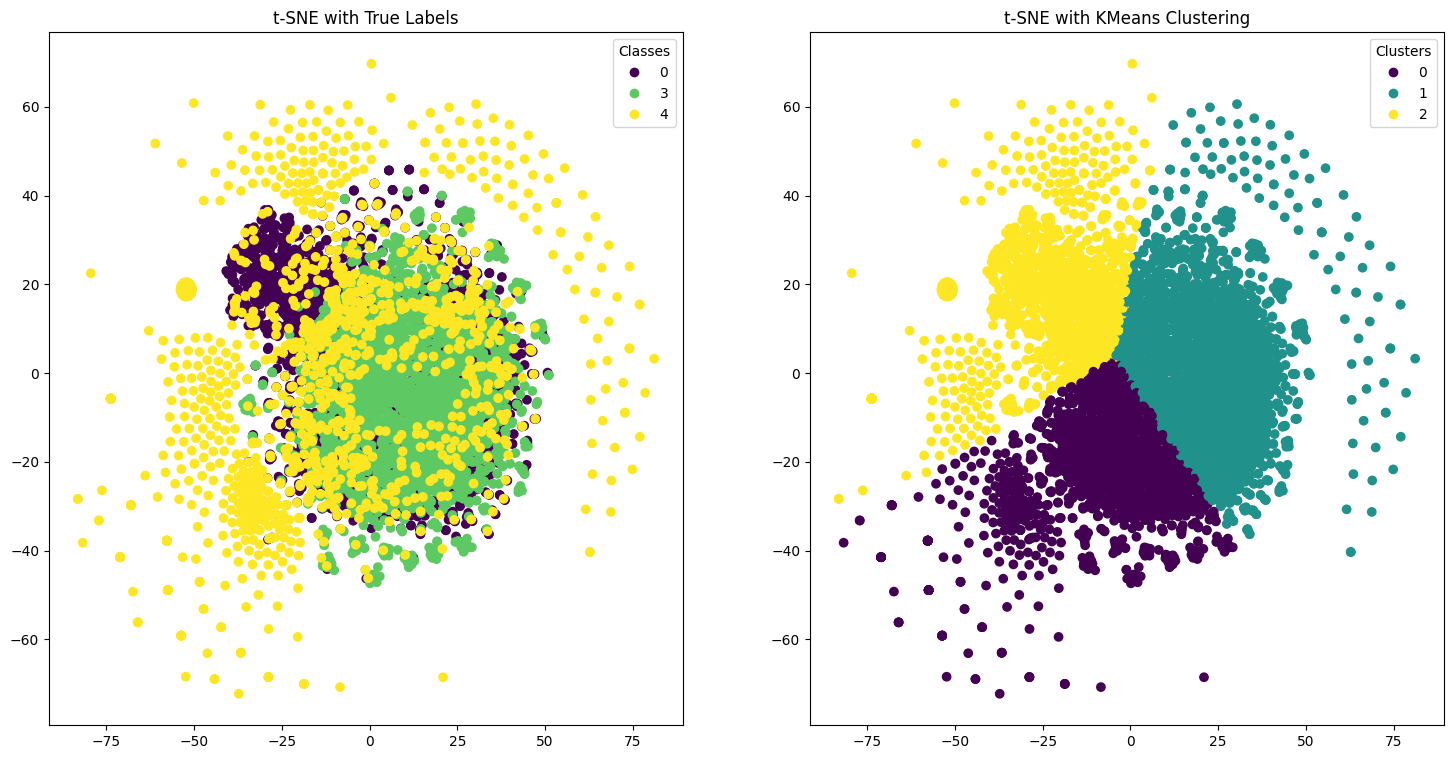

In [26]:
# Perform t-SNE on training data
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust number of clusters if needed
kmeans_labels = kmeans.fit_predict(X_train_tsne)

# Plot t-SNE results with true labels
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis')
plt.title("t-SNE with True Labels")
plt.legend(*scatter.legend_elements(), title="Classes")

# Plot t-SNE results with KMeans labels
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("t-SNE with KMeans Clustering")
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()